In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def imshow(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

In [3]:
def plot(data):
    plt.figure(figsize=(8, 8))
    plt.plot(data)
    plt.show()

In [4]:
image = np.asarray(Image.open('boat.png'))

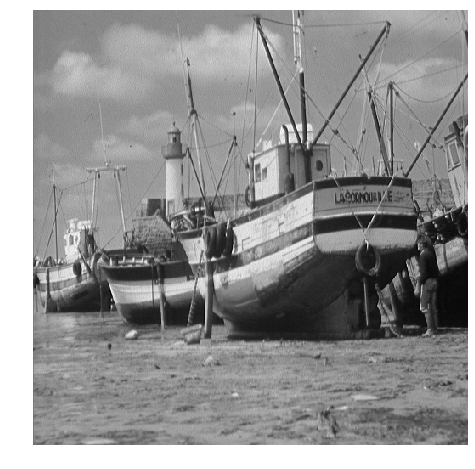

In [5]:
imshow(image)

In [6]:
data = image[256, 0:32]

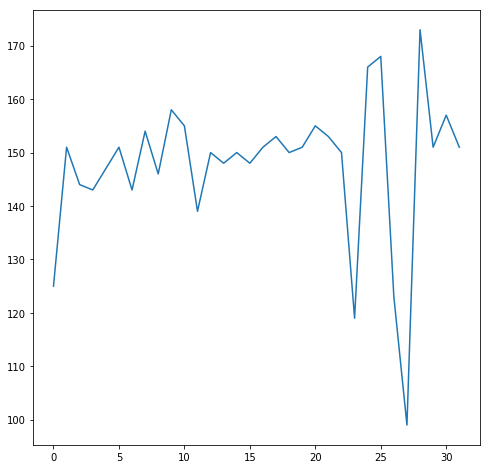

In [7]:
plot(data)

In [8]:
data

array([125, 151, 144, 143, 147, 151, 143, 154, 146, 158, 155, 139, 150,
       148, 150, 148, 151, 153, 150, 151, 155, 153, 150, 119, 166, 168,
       123,  99, 173, 151, 157, 151], dtype=uint8)

In [9]:
a = np.array([0, 1/2, 1, 1/2, 0, 0]) / 2.0
b = np.array([0, -1/8, -1/4, 3/4, -1/4, -1/8]) / 2.0

ai = np.array([-1/8, -1/2, 3/4, -1/2, -1/8, 0]) * 2
bi = np.array([0, 0, 1/4, 1, 1/4, 0]) * 2

In [10]:
def conv(data, a, i):
    return (data[2*i:2*i+len(a)] * a).sum()

In [11]:
def dwt(data, a, b):
    N = len(data)
    data = np.pad(data, [2, 2], 'reflect')
    l = np.empty(N // 2)
    h = np.empty(N // 2)
    for i in range(N // 2):
        l[i] = conv(data, a, i)
        h[i] = conv(data, b, i)
    return l, h

In [12]:
data_l, data_h = dwt(data, a, b)

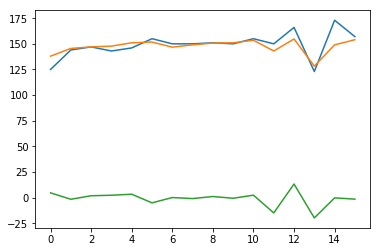

In [13]:
plt.plot(data[::2])
plt.plot(data_l)
plt.plot(data_h)
plt.show()

In [14]:
def join(L, H):
    N = len(L) + len(H)
    data_in = np.empty(N)
    data_in[::2] = L
    data_in[1::2] = H
    return data_in

In [15]:
def idwt(L, H, ai, bi):
    data = join(L, H)
    return join(*dwt(data, ai, bi))

In [16]:
data_rec = idwt(data_l, data_h, ai, bi)

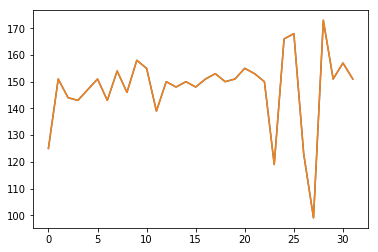

In [17]:
plt.plot(data)
plt.plot(data_rec)
plt.show()

In [18]:
data_rec - data

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [19]:
def conv_row(data, a, i):
    return (data[:, 2*i:2*i+len(a)] * a[None, :]).sum(axis=1)

In [20]:
def conv_col(data, a, i):
    return (data[2*i:2*i+len(a), :] * a[:, None]).sum(axis=0)

In [21]:
def dwt2_row(data, a, b):
    r, c = data.shape
    data = np.pad(data, [[0, 0], [2, 2]], 'reflect')
    l = np.empty((r, c // 2))
    h = np.empty((r, c // 2))
    for i in range(c // 2):
        l[:, i] = conv_row(data, a, i)
        h[:, i] = conv_row(data, b, i)
    return l, h

In [22]:
def dwt2_col(data, a, b):
    r, c = data.shape
    data = np.pad(data, [[2, 2], [0, 0]], 'reflect')
    l = np.empty((r // 2, c))
    h = np.empty((r // 2, c))
    for i in range(r // 2):
        l[i, :] = conv_col(data, a, i)
        h[i, :] = conv_col(data, b, i)
    return l, h

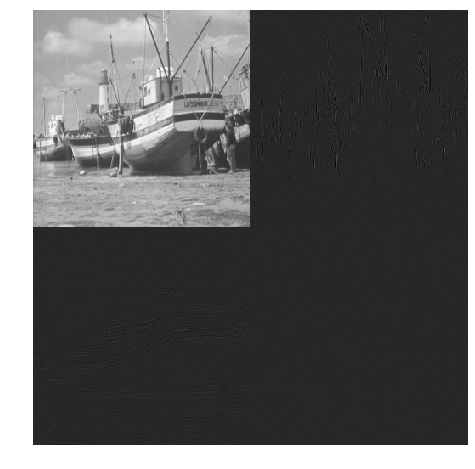

In [23]:
L, H = dwt2_col(image, a, b)
LL, LH = dwt2_row(L, a, b)
HL, HH = dwt2_row(H, a, b)
image2 = np.block([[LL, LH], [HL, HH]])
imshow(image2)

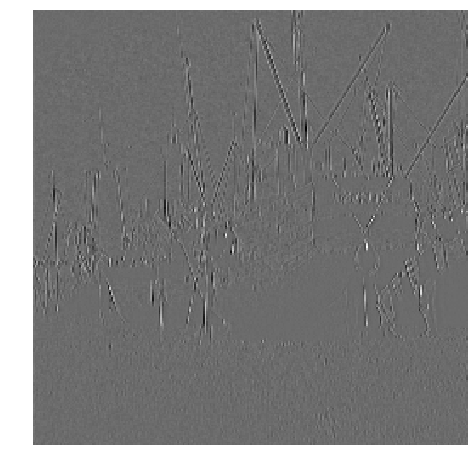

In [24]:
imshow(LH)

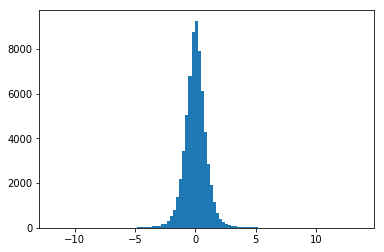

In [25]:
plt.hist(HH.ravel(), bins=100)
plt.show()

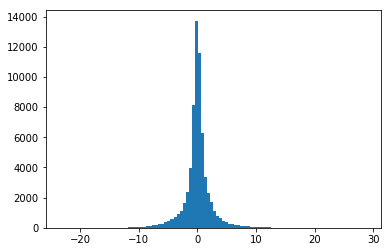

In [26]:
plt.hist(HL.ravel(), bins=100)
plt.show()

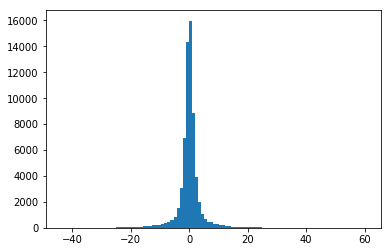

In [27]:
plt.hist(LH.ravel(), bins=100)
plt.show()

In [28]:
def rdwt2d(image, a, b, base=8):
    w, h = image.shape
    assert w == h
    N = w
    data = image.astype(float).copy()
    while N > base:
        L, H = dwt2_col(data[:N, :N], a, b)
        LL, LH = dwt2_row(L, a, b)
        HL, HH = dwt2_row(H, a, b)
        data[:N, :N] = np.block([[LL, LH], [HL, HH]])
        N //= 2
    return data

In [29]:
image_t = rdwt2d(image, a, b)

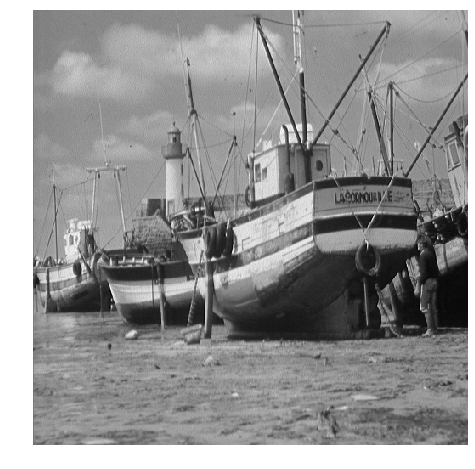

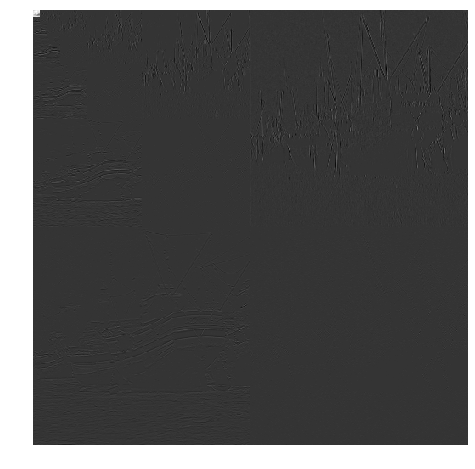

In [30]:
imshow(image)
imshow(image_t)

In [31]:
def join2_row(L, H):
    N = L.shape[1] + H.shape[1]
    data_in = np.empty((N, N))
    data_in[:, ::2] = L
    data_in[:, 1::2] = H
    return data_in

def join2_col(L, H):
    N = L.shape[0] + H.shape[0]
    data_in = np.empty((N, N))
    data_in[::2, :] = L
    data_in[1::2, :] = H
    return data_in

In [32]:
def ridwt2d(data, ai, bi, base=8):
    w, h = data.shape
    assert w == h
    data = data.astype(float).copy()
    N = base * 2
    while N <= w:
        row = join2_row(data[:N, :N//2], data[:N, N//2:N])
        L, H = dwt2_row(row, ai, bi)
        data[:N, :N] = join2_row(L, H)
        col = join2_col(data[:N//2, :N], data[N//2:N, :N])
        L, H = dwt2_col(col, ai, bi)
        data[:N, :N] = join2_col(L, H)
        N *= 2
    return data

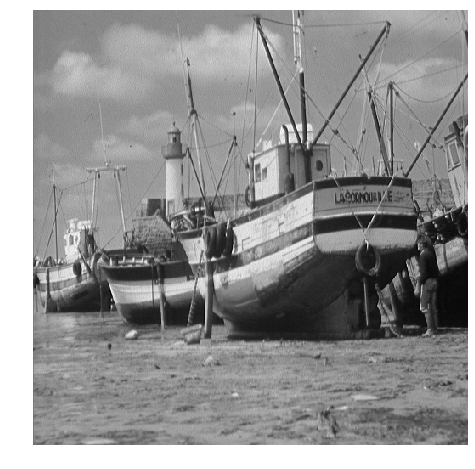

In [33]:
imshow(ridwt2d(image_t, ai, bi, base=8))

In [34]:
image_t.max()

168.35083550214767

In [35]:
len(image_t[abs(image_t) < 1.5])

191274

In [36]:
512 * 512

262144

In [37]:
191 / 262

0.7290076335877863

In [38]:
image_t2 = image_t.copy()
image_t2[abs(image_t) < 1.5] = 0
len(image_t2[image_t2 == 0])

191274

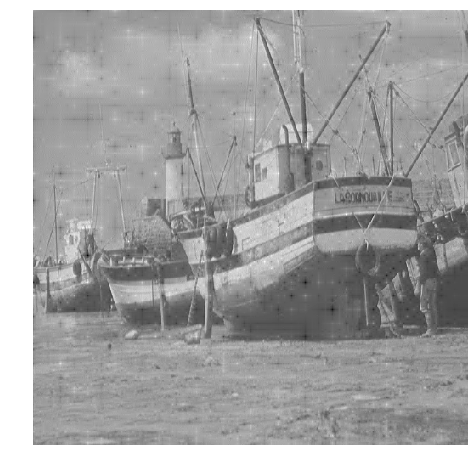

In [39]:
imshow(ridwt2d(image_t2, ai, bi, base=8))

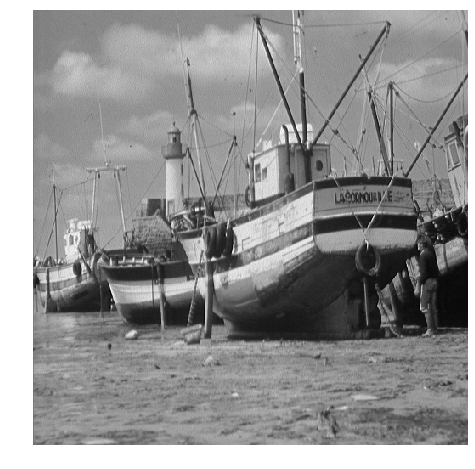

In [40]:
imshow(image)